# User Churn Prediction
#### In this notebook, I demonstrate how to use tree-ensemble methods to predict user churn rate from telecom usage data.

The two main packages used are **pandas** and **sklearn**.

In [91]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import itertools
from sklearn import model_selection
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
#from sklearn.linear_model import LogisticRegression
#from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve, confusion_matrix
from sklearn import metrics

First, we load the csv data and examine the date features.

In [92]:
churn_df = pd.read_csv('data/churn.all')

In [93]:
churn_df.head()

,state,account_length,area_code,phone_number,intl_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,...,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,churned
0,KS,128,415,382-4657,no,yes,25,265.1,110,45.07,...,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False.
1,OH,107,415,371-7191,no,yes,26,161.6,123,27.47,...,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False.
2,NJ,137,415,358-1921,no,no,0,243.4,114,41.38,...,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False.
3,OH,84,408,375-9999,yes,no,0,299.4,71,50.90,...,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False.
4,OK,75,415,330-6626,yes,no,0,166.7,113,28.34,...,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False.


In [94]:
churn_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 21 columns):
state                            5000 non-null object
account_length                   5000 non-null int64
area_code                        5000 non-null int64
phone_number                     5000 non-null object
intl_plan                        5000 non-null object
voice_mail_plan                  5000 non-null object
number_vmail_messages            5000 non-null int64
total_day_minutes                5000 non-null float64
total_day_calls                  5000 non-null int64
total_day_charge                 5000 non-null float64
total_eve_minutes                5000 non-null float64
total_eve_calls                  5000 non-null int64
total_eve_charge                 5000 non-null float64
total_night_minutes              5000 non-null float64
total_night_calls                5000 non-null int64
total_night_charge               5000 non-null float64
total_intl_minutes           

In [95]:
print ("%d data" % churn_df.shape[0])
print ("%d columns (%d features)" %(churn_df.shape[1], churn_df.shape[1]-1))

5000 data
21 columns (20 features)


We see that there are 5000 samples in total. We have 20 available features, and 1 binary predcitor (churn/ not churn). Next, we are going to clean and preprocess the data. Specifically, the "Yes/No" and "True/False" type features can be converted into binary representation. 

In [96]:
def convert_bool(string):
    string = string.lower()
    if 'yes' in string or 'true' in string:
        return 1
    elif 'no' in string or 'false' in string:
        return 0
    else:
        return float('nan')

In [97]:
# convert yes/no true/false to boolean values
churn_df['voice_mail_plan'] = churn_df['voice_mail_plan'].apply(convert_bool)
churn_df['intl_plan'] = churn_df['intl_plan'].apply(convert_bool)
churn_df['churned'] = churn_df['churned'].apply(convert_bool)

Now that we've succesfully updated the data feature space, we can quickly view the updates by using <code>head()</code>. We can also get an estimate of whether data is balanced by examining the percentage of <code>churned</code> = 1.

In [54]:
churn_df.head()

,state,account_length,area_code,phone_number,intl_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,...,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,churned
0,KS,128,415,382-4657,0,1,25,265.1,110,45.07,...,99,16.78,244.7,91,11.01,10.0,3,2.70,1,0
1,OH,107,415,371-7191,0,1,26,161.6,123,27.47,...,103,16.62,254.4,103,11.45,13.7,3,3.70,1,0
2,NJ,137,415,358-1921,0,0,0,243.4,114,41.38,...,110,10.30,162.6,104,7.32,12.2,5,3.29,0,0
3,OH,84,408,375-9999,1,0,0,299.4,71,50.90,...,88,5.26,196.9,89,8.86,6.6,7,1.78,2,0
4,OK,75,415,330-6626,1,0,0,166.7,113,28.34,...,122,12.61,186.9,121,8.41,10.1,3,2.73,3,0


In [55]:
print('Churn rate: %d/%d' %(np.sum(churn_df['churned'] == 1), churn_df.shape[0]))

Churn rate: 707/5000


In [99]:
# experimented with adding state features as a categorical feature, but this did not improved the model performance
#churn_df['state'] = pd.Categorical(churn_df['state'])
#dfDummies = pd.get_dummies(churn_df['state'], prefix = 'state')
#churn_df = pd.concat([churn_df, dfDummies], axis=1)
#list(churn_df)

#stategrouped = churn_df.groupby(['state', 'churned']).size()
#stategrouped.groupby(level=[0]).apply(lambda g: g / g.sum()

We dropped 3 features which were deemed irrelevant to the predection (the *state* feature may be added back in the future as a categorical feature), and separated out the features `churn_X` and label `churn_Y`. 

In [100]:
# Drop some useless columns
to_drop = ['state','area_code','phone_number','churned']
churn_X = churn_df.drop(to_drop, axis=1)
churn_Y = churn_df['churned']

We can quickly visualize the distribution of each feature as well as the correlation by calling `hist()` and `corr()`.

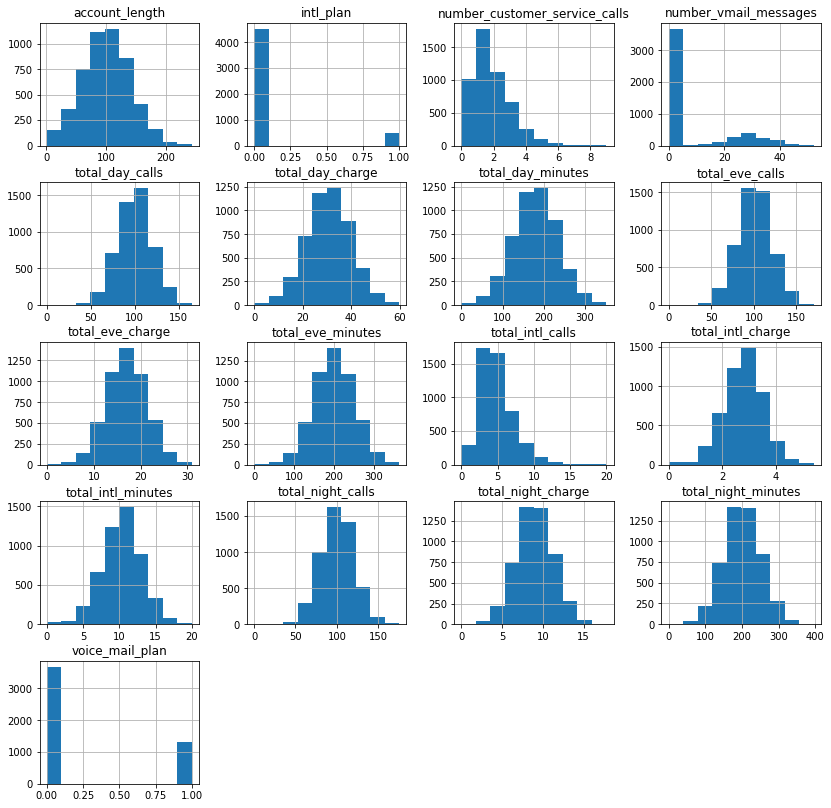

In [101]:
hist = churn_X.hist(figsize = (14, 14))

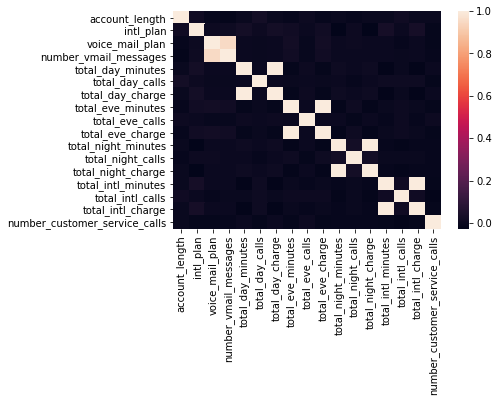

In [24]:
corr = churn_X.corr()
sns.heatmap(corr)

Next, the 5000 data samples are split into training and validation sets (4/1).

In [102]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(churn_X, churn_Y, test_size=0.2)

print('training data has %d observation with %d features'% X_train.shape)
print('test data has %d observation with %d features'% X_test.shape)

training data has 4000 observation with 17 features
test data has 1000 observation with 17 features


When choosing the machine learning models, I focused on several tree-based models because of their superior perforamance compared to logistic regression and SVM without fine tuning hyper-parameters.

In [103]:
#clf_logistic = LogisticRegression()
clf_RF = RandomForestClassifier()
#clf_SVM = SVC(kernel='linear', C=1)
clf_gb = GradientBoostingClassifier()
clf_ab = AdaBoostClassifier()

To select the best model, I used 5-fold cross-validation, and selected the mean F1 score of each model as the metric to compare different models. I used the F1 score because I think both the precision and recall are important to the user churn rate prediction. Since the dataset was not overly imbalanced (around 14% positive reponses), I did not apply special treatment to the weights.

In [114]:
model_names = ['RF', 'GB', 'AB']
model_list = [clf_RF, clf_gb, clf_ab]

count = 0
for classifier in model_list:
    cv_score = model_selection.cross_val_score(classifier, X_train, y_train, cv=5, scoring='f1')
    print('Binary F1 score of %s is: %.3f'%(model_names[count], cv_score.mean()))
    count += 1

Binary F1 score of RF is: 0.801
Binary F1 score of GB is: 0.812
Binary F1 score of AB is: 0.491


After the initial attempt, we found that the gradient boosting (GB) model performs the best. Therefore, I chose to further fine tune the GB model to achieve higher F1 score. I leveraged the `GridSearchCV` function to gradually narrow down the optimal hyper-parameters, which include `n_estimators`, `max_depth`, `min_samples_split` and `min_samples_leaf`.

In [36]:
def print_grid_search_metrics(gs):
    print ("Best score: %0.3f" % gs.best_score_)
    print ("Best parameters set:")
    best_parameters = gs.best_params_
    for param_name in sorted(parameters.keys()):
        print("\t%s: %r" % (param_name, best_parameters[param_name]))

In [131]:
parameters = {
    'learning_rate' : [0.05, 0.1, 0.2],
    'n_estimators' : [100, 500, 1000, 1500]
}

Grid = GridSearchCV(GradientBoostingClassifier(), param_grid=parameters, scoring='f1', cv=5)
Grid.fit(X_train, y_train)

print_grid_search_metrics(Grid)
best_model = Grid.best_estimator_

Best score: 0.823
Best parameters set:
	learning_rate: 0.05
	n_estimators: 1000


After the best model is chosen, I used the best model to fit the whole training data, and calculated the importance of each feature by referencing the `feature_importances_` field. The top 3 most important features are **total day charge**, **number of customer service calls** and **total evening minutes**.

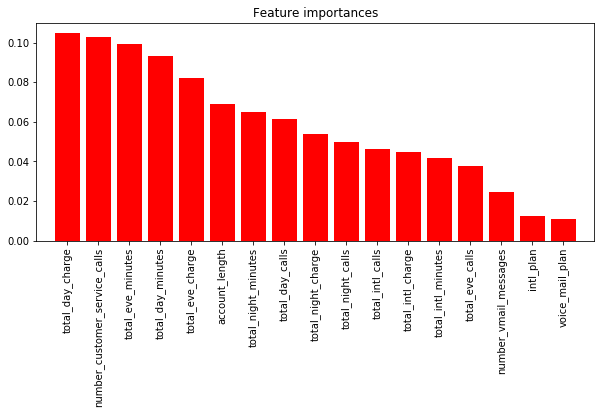

In [132]:
#model = clf_gb
model = best_model
model.fit(X_train, y_train)
importances = model.feature_importances_
#std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)

indices = np.argsort(importances)[::-1]

# Plot the feature importances of the forest
plt.figure(figsize=[10, 4])
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), importances[indices], color="r", 
        #yerr=std[indices], 
        align="center")
labels = [list(churn_X)[i] for i in indices]
plt.xticks(range(X_train.shape[1]), labels, rotation=90)

plt.xlim([-1, X_train.shape[1]])
plt.show()

I plotted the ROC curve, and calculated the AUC to be 0.919 for the best model.

0.9190325435729849


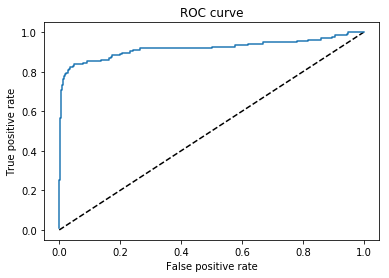

In [133]:
y_pred_rf = model.predict_proba(X_test)[:, 1] # col0 = class 0; col1 = class 1
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_rf)
print(metrics.auc(fpr_rf,tpr_rf))

plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.show()

In [29]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

Finally, I plotted the confusion matrix, where the predictions were made on the validation set. We can see that of all the churned samples, 74% of them were correctly identified. The type I error (false positive) is less than the type II error (false negative), which implies that the precision is higher than the recall. We achieved an overall accuracy of 95.5%.

Accuracy: 0.955
F1 score: 0.8163265306122449
Precision: 0.9174311926605505
Recall: 0.7352941176470589
Normalized confusion matrix
[[0.98958333 0.01041667]
 [0.26470588 0.73529412]]


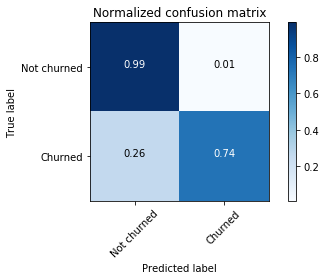

In [134]:
y_pred = model.predict(X_test)
print('Accuracy: ' + str(metrics.accuracy_score(y_test, y_pred)))
print('F1 score: ' + str(metrics.f1_score(y_test, y_pred)))
print('Precision: ' + str(metrics.precision_score(y_test, y_pred)))
print('Recall: ' + str(metrics.recall_score(y_test, y_pred)))

cnf_matrix = confusion_matrix(y_test, y_pred)
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Not churned', 'Churned'], normalize=True,
                      title='Normalized confusion matrix')

plt.show()